# Autoencoder-Based Drift Detection: Q1 vs Q3

**Capstone Project** - Marina Melkonyan | American University of Armenia

**Goal**: Can we use autoencoders to detect feature drift in IoT sensor imagery?  
**Approach**: Train a VAE on Q1+Q3 streetlight camera images, then compare latent representations to quantify distributional shift.

| Step | Description |
|------|-------------|
| 1 | Load Q1 (winter) and Q3 (summer) daytime streetlight images |
| 2 | Extract RGB histogram features (768-dim) |
| 3 | Train a Variational Autoencoder (VAE) |
| 4 | Encode Q1 and Q3 into 64-dim latent space |
| 5 | Measure drift: MI-LHD, STKA, Euclidean distance |
| 6 | Detect anomalies via reconstruction error |
| 7 | Validate with metadata (GPS, faults, brightness) |

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from PIL import Image

# Project imports
sys.path.insert(0, os.path.abspath('../src'))
from processing import create_q1q3_datasets, batch_extract_features, add_temporal_metadata
from autoencoder import ImageAutoencoder, extract_latent_representations, vae_loss
from metrics import (
    metadata_invariant_latent_histogram_divergence,
    spatio_temporal_kernel_alignment,
    compute_euclidean_drift
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

Device: cuda


## 1. Load Q1 / Q3 Data

Load pre-filtered daytime images from the StreetCare Bristol dataset.  
- **Q1** (Jan-Mar): Winter lighting conditions  
- **Q3** (Jul-Sep): Summer lighting conditions

In [2]:
os.chdir(os.path.abspath('..'))

q1_data, q3_data = create_q1q3_datasets()
q1_data = add_temporal_metadata(q1_data)
q3_data = add_temporal_metadata(q3_data)

print(f'Q1: {len(q1_data)} images  |  Years: {q1_data["year"].min()}-{q1_data["year"].max()}')
print(f'Q3: {len(q3_data)} images  |  Years: {q3_data["year"].min()}-{q3_data["year"].max()}')
print(f'Total: {len(q1_data) + len(q3_data)}')

 Loaded Q1 (daytime): 1919 images, 4 years
 Loaded Q3 (daytime): 1889 images, 5 years
 Daynight verification: All values are [0.]
Q1: 1919 images  |  Years: 2022-2025
Q3: 1889 images  |  Years: 2021-2025
Total: 3808


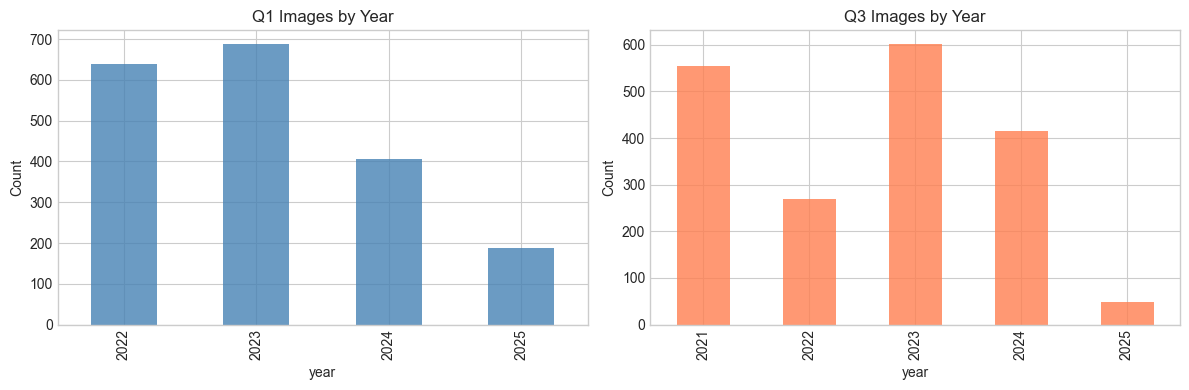

In [3]:
# Year distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
q1_data['year'].value_counts().sort_index().plot.bar(ax=axes[0], color='steelblue', alpha=0.8)
axes[0].set_title('Q1 Images by Year')
axes[0].set_ylabel('Count')
q3_data['year'].value_counts().sort_index().plot.bar(ax=axes[1], color='coral', alpha=0.8)
axes[1].set_title('Q3 Images by Year')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

## 2. Feature Extraction

Extract 768-dimensional RGB histogram features (256 bins x 3 channels) from each image.

In [4]:
q1_features, q1_paths = batch_extract_features(q1_data, feature_type='histogram')
q3_features, q3_paths = batch_extract_features(q3_data, feature_type='histogram')

print(f'Q1 features: {q1_features.shape}')
print(f'Q3 features: {q3_features.shape}')

# Sanity: check features are non-zero
q1_nonzero = np.count_nonzero(q1_features.sum(axis=1))
q3_nonzero = np.count_nonzero(q3_features.sum(axis=1))
print(f'Non-zero feature vectors: Q1={q1_nonzero}/{len(q1_features)}, Q3={q3_nonzero}/{len(q3_features)}')

Q1 features: (1919, 768)
Q3 features: (1889, 768)
Non-zero feature vectors: Q1=1919/1919, Q3=1889/1889


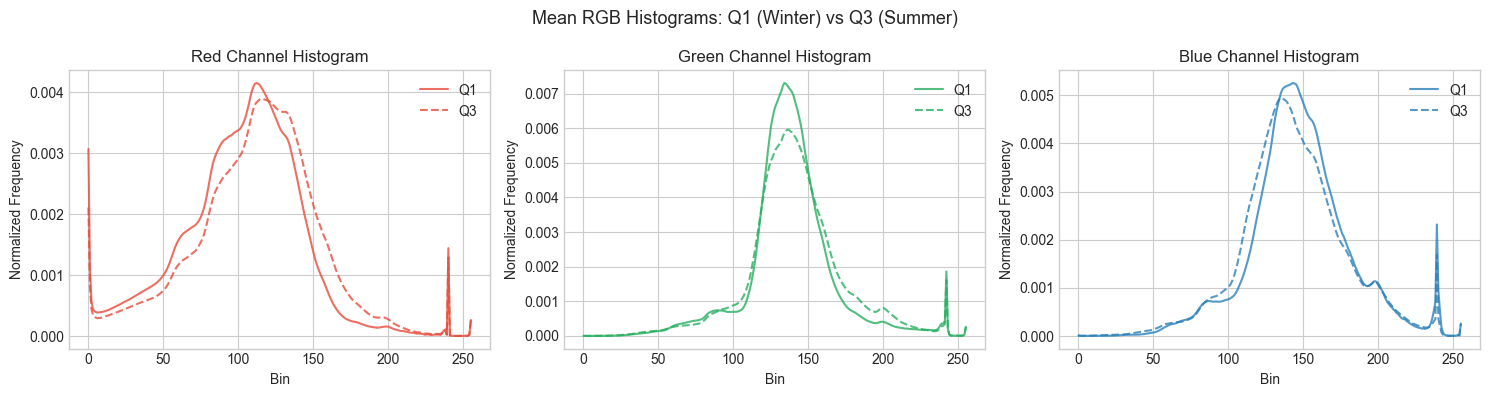

In [5]:
# Compare mean histograms: Q1 vs Q3
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
channels = ['Red', 'Green', 'Blue']
colors = ['#e74c3c', '#27ae60', '#2980b9']

for i, (ch, color) in enumerate(zip(channels, colors)):
    start, end = i * 256, (i + 1) * 256
    axes[i].plot(q1_features[:, start:end].mean(axis=0), label='Q1', alpha=0.8, color=color)
    axes[i].plot(q3_features[:, start:end].mean(axis=0), label='Q3', alpha=0.8, color=color, linestyle='--')
    axes[i].set_title(f'{ch} Channel Histogram')
    axes[i].set_xlabel('Bin')
    axes[i].set_ylabel('Normalized Frequency')
    axes[i].legend()

plt.suptitle('Mean RGB Histograms: Q1 (Winter) vs Q3 (Summer)', fontsize=13)
plt.tight_layout()
plt.show()

### 2.1 Per-Channel Drift Decomposition

Which color channel contributes the most to distributional shift?

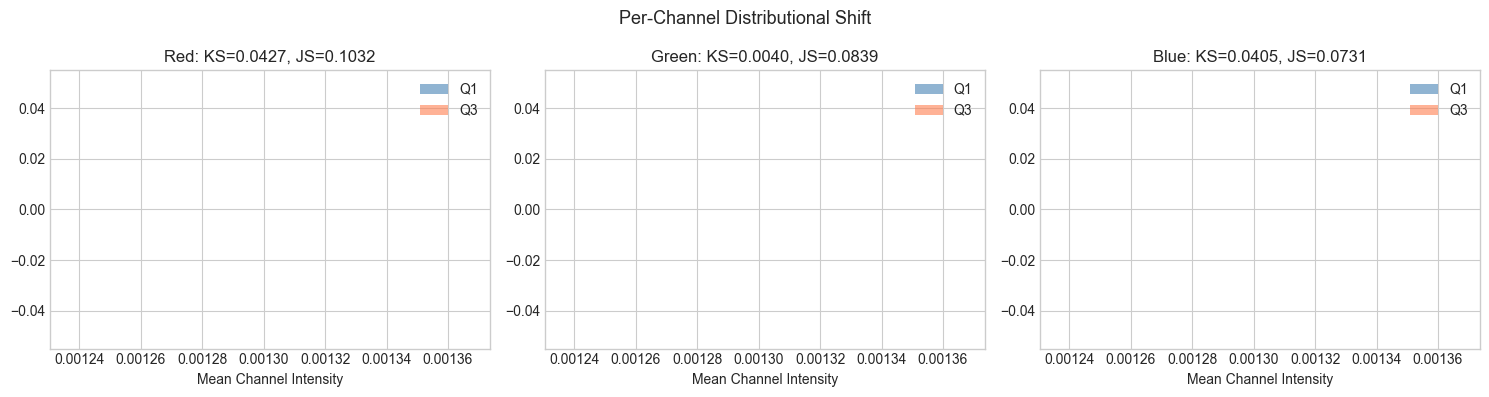


Per-Channel Drift Contribution:
       KS Statistic  KS p-value  JS Divergence  Contribution (%)
Red        0.042712    0.059543       0.103231              39.7
Green      0.003970    1.000000       0.083886              32.2
Blue       0.040478    0.084999       0.073117              28.1


In [6]:
# Per-channel KS test and Jensen-Shannon divergence
from scipy.spatial.distance import jensenshannon

channels = {'Red': (0, 256), 'Green': (256, 512), 'Blue': (512, 768)}
channel_results = {}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors_map = {'Red': '#e74c3c', 'Green': '#27ae60', 'Blue': '#2980b9'}

for idx, (ch_name, (start, end)) in enumerate(channels.items()):
    q1_ch = q1_features[:, start:end].mean(axis=1)
    q3_ch = q3_features[:, start:end].mean(axis=1)
    
    ks_stat, ks_p = ks_2samp(q1_ch, q3_ch)
    
    # Jensen-Shannon divergence on mean histograms
    q1_hist = q1_features[:, start:end].mean(axis=0)
    q3_hist = q3_features[:, start:end].mean(axis=0)
    q1_hist_norm = q1_hist / (q1_hist.sum() + 1e-10)
    q3_hist_norm = q3_hist / (q3_hist.sum() + 1e-10)
    js_div = jensenshannon(q1_hist_norm, q3_hist_norm)
    
    channel_results[ch_name] = {'ks_stat': ks_stat, 'ks_p': ks_p, 'js_div': js_div}
    
    axes[idx].hist(q1_ch, bins=50, alpha=0.6, density=True, label='Q1', color='steelblue')
    axes[idx].hist(q3_ch, bins=50, alpha=0.6, density=True, label='Q3', color='coral')
    axes[idx].set_title(f'{ch_name}: KS={ks_stat:.4f}, JS={js_div:.4f}')
    axes[idx].set_xlabel('Mean Channel Intensity')
    axes[idx].legend()

plt.suptitle('Per-Channel Distributional Shift', fontsize=13)
plt.tight_layout()
plt.show()

# Summary table
ch_df = pd.DataFrame(channel_results).T
ch_df.columns = ['KS Statistic', 'KS p-value', 'JS Divergence']
ch_df['Contribution (%)'] = (ch_df['JS Divergence'] / ch_df['JS Divergence'].sum() * 100).round(1)
print('\nPer-Channel Drift Contribution:')
print(ch_df.to_string())

## 3. Train Variational Autoencoder (Q1 Only)

**Key change**: Train exclusively on Q1 (winter) data so the autoencoder learns the Q1 distribution as baseline.  
Q3 images that differ from learned Q1 patterns will produce higher reconstruction errors — a direct drift signal.

Architecture: `768 -> 512 -> 256 -> 128 -> 64 (latent) -> 128 -> 256 -> 512 -> 768`  
Loss: Binary Cross-Entropy + KL Divergence (beta=0.4)

In [7]:
# Train on Q1 ONLY - this is the key methodological improvement
# Q1 normalization params will be used as baseline for Q3 as well
X_q1 = q1_features.copy()
X_q1_min = X_q1.min(axis=0)
X_q1_range = X_q1.max(axis=0) - X_q1_min + 1e-8
X_q1_norm = (X_q1 - X_q1_min) / X_q1_range

# Store normalization params for later use
norm_params = {'min': X_q1_min, 'range': X_q1_range}

X_tensor = torch.FloatTensor(X_q1_norm).to(DEVICE)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

LATENT_DIM = 64
model = ImageAutoencoder(input_dim=768, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = {'total_loss': [], 'reconstruction_loss': [], 'kl_loss': []}
EPOCHS = 100

print(f'Training VAE on Q1 only ({len(X_q1_norm)} samples, latent_dim={LATENT_DIM}, epochs={EPOCHS})...')

for epoch in range(EPOCHS):
    total_loss = recon_loss = kl_loss_val = 0
    for (x,) in dataloader:
        optimizer.zero_grad()
        recon, mu, logvar, z = model(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        recon_loss += nn.functional.binary_cross_entropy(recon, x, reduction='mean').item()
        kl_loss_val += (-0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())).item()
    
    n = len(dataloader)
    history['total_loss'].append(total_loss / n)
    history['reconstruction_loss'].append(recon_loss / n)
    history['kl_loss'].append(kl_loss_val / n)
    
    if (epoch + 1) % 10 == 0:
        print(f'  Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss/n:.6f}')

print(f'\nFinal reconstruction loss: {history["reconstruction_loss"][-1]:.6f}')
print(f'Final KL divergence:       {history["kl_loss"][-1]:.6f}')

Training VAE on Q1 only (1919 samples, latent_dim=64, epochs=100)...
  Epoch 10/100 - Loss: 0.237950
  Epoch 20/100 - Loss: 0.234716
  Epoch 30/100 - Loss: 0.231835
  Epoch 40/100 - Loss: 0.228843
  Epoch 50/100 - Loss: 0.227829
  Epoch 60/100 - Loss: 0.226650
  Epoch 70/100 - Loss: 0.226124
  Epoch 80/100 - Loss: 0.226380
  Epoch 90/100 - Loss: 0.226333
  Epoch 100/100 - Loss: 0.225465

Final reconstruction loss: 0.215733
Final KL divergence:       0.024330


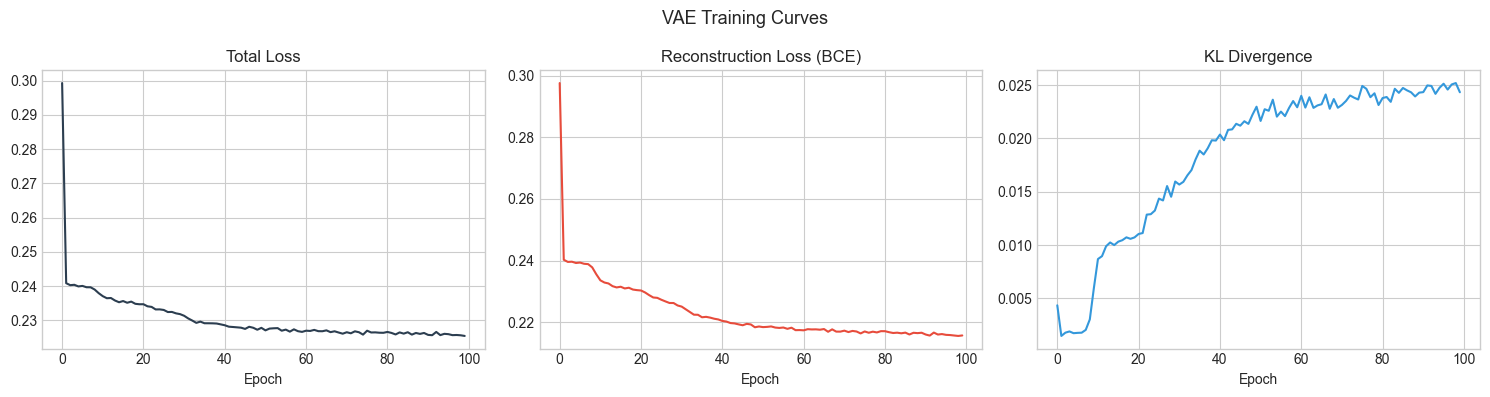

In [8]:
# Training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(history['total_loss'], color='#2c3e50')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')

axes[1].plot(history['reconstruction_loss'], color='#e74c3c')
axes[1].set_title('Reconstruction Loss (BCE)')
axes[1].set_xlabel('Epoch')

axes[2].plot(history['kl_loss'], color='#3498db')
axes[2].set_title('KL Divergence')
axes[2].set_xlabel('Epoch')

plt.suptitle('VAE Training Curves', fontsize=13)
plt.tight_layout()
plt.show()

## 4. Latent Space Analysis

Encode Q1 and Q3 into the 64-dimensional latent space and visualize the distributions.

In [9]:
# Extract latent representations using Q1-based normalization
model.eval()

# Normalize both using Q1 baseline params
q1_norm = (q1_features - norm_params['min']) / norm_params['range']
q3_norm = (q3_features - norm_params['min']) / norm_params['range']
q3_norm = np.clip(q3_norm, 0, 1)  # Clip Q3 to valid range

with torch.no_grad():
    q1_t = torch.FloatTensor(q1_norm).to(DEVICE)
    q3_t = torch.FloatTensor(q3_norm).to(DEVICE)
    latent_q1 = model.get_latent(q1_t).cpu().numpy()
    latent_q3 = model.get_latent(q3_t).cpu().numpy()

print(f'Latent Q1: {latent_q1.shape}')
print(f'Latent Q3: {latent_q3.shape}')
print(f'\nLatent dim means (Q1): min={latent_q1.mean(0).min():.4f}, max={latent_q1.mean(0).max():.4f}')
print(f'Latent dim means (Q3): min={latent_q3.mean(0).min():.4f}, max={latent_q3.mean(0).max():.4f}')

Latent Q1: (1919, 64)
Latent Q3: (1889, 64)

Latent dim means (Q1): min=-0.0199, max=0.0765
Latent dim means (Q3): min=-0.2626, max=0.2010


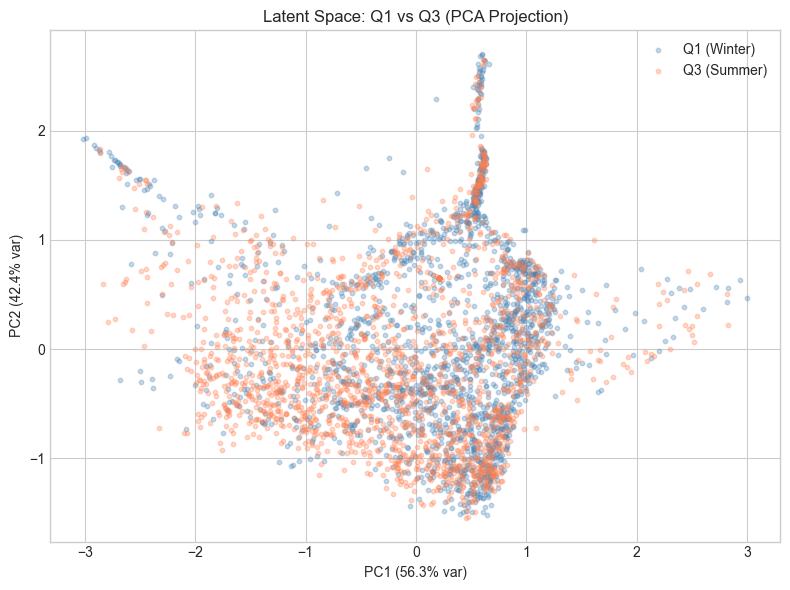

In [10]:
# PCA projection of latent space for visualization
from sklearn.decomposition import PCA

combined = np.vstack([latent_q1, latent_q3])
labels = ['Q1'] * len(latent_q1) + ['Q3'] * len(latent_q3)

pca = PCA(n_components=2)
proj = pca.fit_transform(combined)

fig, ax = plt.subplots(figsize=(8, 6))
n1 = len(latent_q1)
ax.scatter(proj[:n1, 0], proj[:n1, 1], alpha=0.3, s=10, label='Q1 (Winter)', color='steelblue')
ax.scatter(proj[n1:, 0], proj[n1:, 1], alpha=0.3, s=10, label='Q3 (Summer)', color='coral')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax.set_title('Latent Space: Q1 vs Q3 (PCA Projection)')
ax.legend()
plt.tight_layout()
plt.show()

Computing t-SNE (this may take ~30s)...


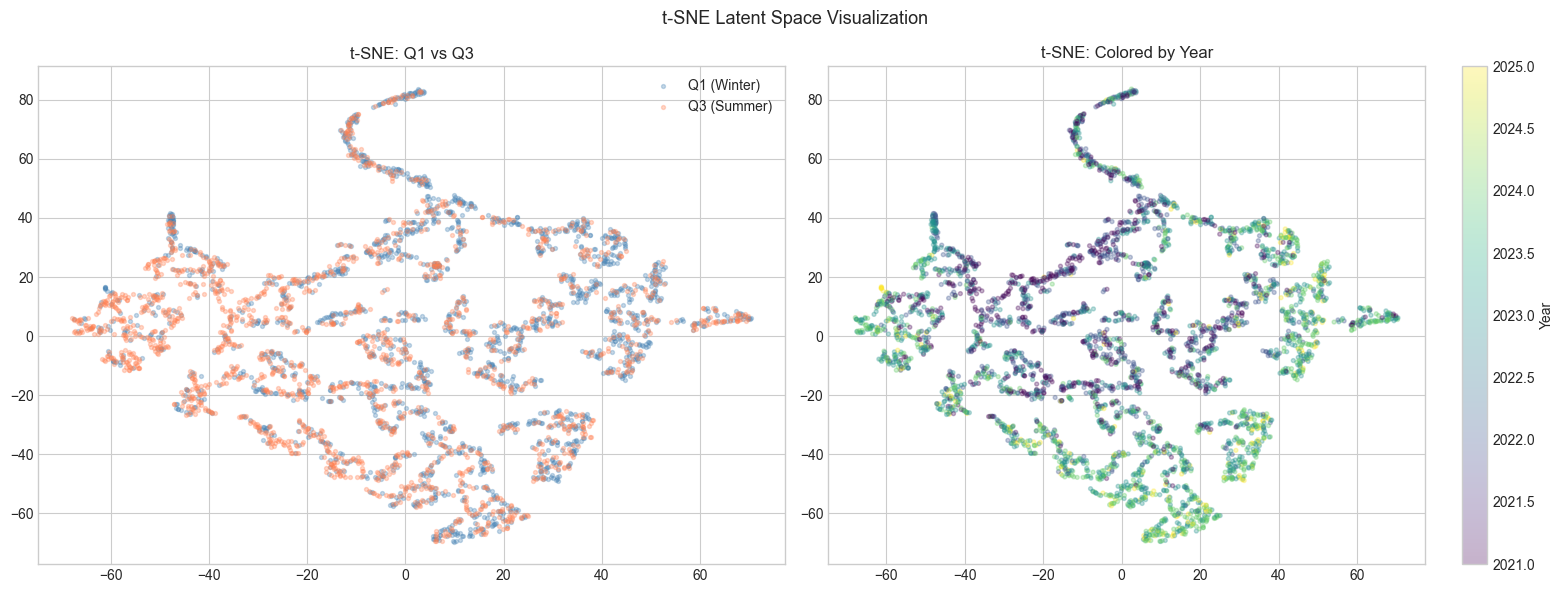

In [11]:
# t-SNE visualization — reveals non-linear cluster structure
print('Computing t-SNE (this may take ~30s)...')
combined = np.vstack([latent_q1, latent_q3])
n1 = len(latent_q1)

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
proj_tsne = tsne.fit_transform(combined)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Colored by quarter
axes[0].scatter(proj_tsne[:n1, 0], proj_tsne[:n1, 1], alpha=0.3, s=8, label='Q1 (Winter)', color='steelblue')
axes[0].scatter(proj_tsne[n1:, 0], proj_tsne[n1:, 1], alpha=0.3, s=8, label='Q3 (Summer)', color='coral')
axes[0].set_title('t-SNE: Q1 vs Q3')
axes[0].legend()

# Colored by year
years_q1 = q1_data['year'].values
years_q3 = q3_data['year'].values
all_years = np.concatenate([years_q1, years_q3])
scatter = axes[1].scatter(proj_tsne[:, 0], proj_tsne[:, 1], c=all_years, cmap='viridis', alpha=0.3, s=8)
plt.colorbar(scatter, ax=axes[1], label='Year')
axes[1].set_title('t-SNE: Colored by Year')

plt.suptitle('t-SNE Latent Space Visualization', fontsize=13)
plt.tight_layout()
plt.show()

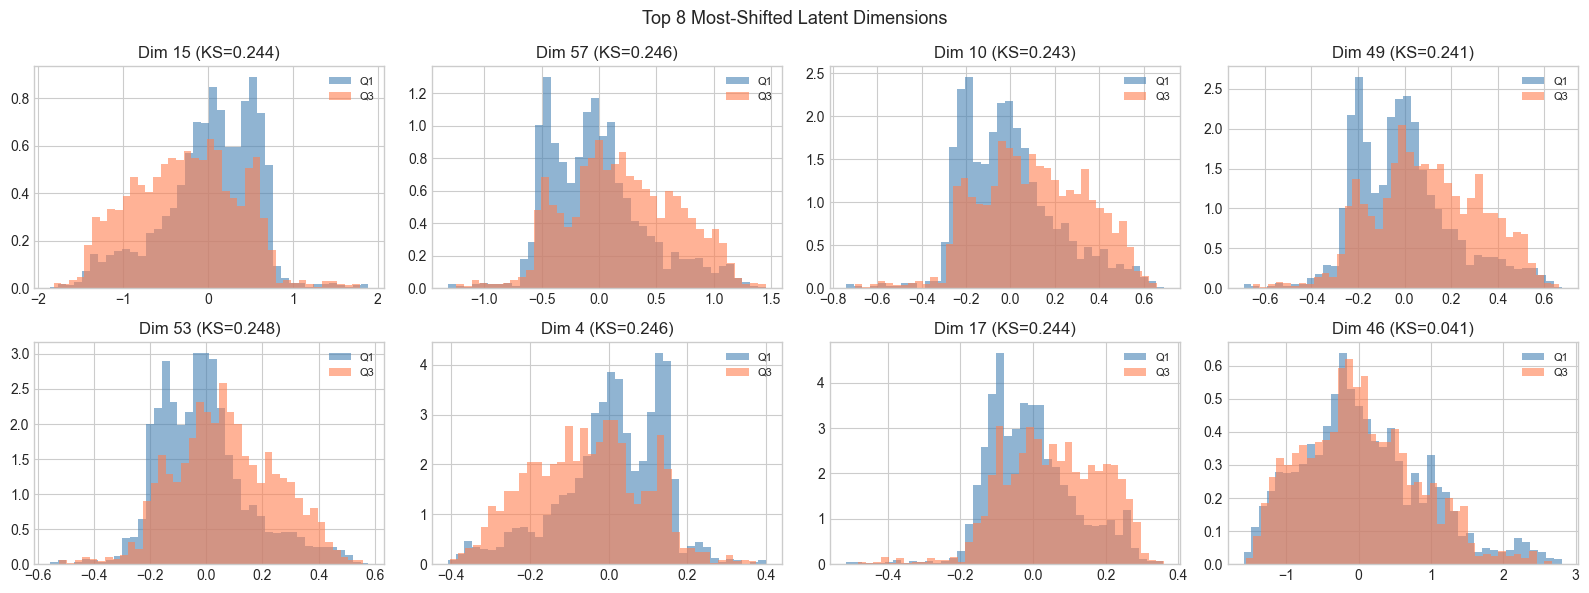

In [12]:
# Per-dimension distribution comparison (top 8 most-shifted dimensions)
dim_shifts = np.abs(latent_q1.mean(0) - latent_q3.mean(0))
top_dims = np.argsort(dim_shifts)[-8:][::-1]

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
for idx, dim in enumerate(top_dims):
    ax = axes[idx // 4, idx % 4]
    ax.hist(latent_q1[:, dim], bins=40, alpha=0.6, density=True, label='Q1', color='steelblue')
    ax.hist(latent_q3[:, dim], bins=40, alpha=0.6, density=True, label='Q3', color='coral')
    ks_stat, ks_p = ks_2samp(latent_q1[:, dim], latent_q3[:, dim])
    ax.set_title(f'Dim {dim} (KS={ks_stat:.3f})')
    ax.legend(fontsize=8)

plt.suptitle('Top 8 Most-Shifted Latent Dimensions', fontsize=13)
plt.tight_layout()
plt.show()

## 5. Drift Metrics

Three complementary drift metrics:
- **MI-LHD**: Jensen-Shannon divergence across latent histogram bins  
- **STKA**: RBF kernel alignment between Q1 and Q3 gram matrices  
- **Euclidean**: Distance between latent centroids

In [13]:
mi_lhd = metadata_invariant_latent_histogram_divergence(latent_q1, latent_q3)
stka = spatio_temporal_kernel_alignment(latent_q1, latent_q3)
euclidean_dist = compute_euclidean_drift(latent_q1, latent_q3)

drift_magnitude = (0.5 * mi_lhd + 0.3 * (1 - stka) + 0.2 * min(1.0, euclidean_dist)) * 100

print('DRIFT METRICS')
print('=' * 50)
print(f'MI-LHD (histogram divergence):  {mi_lhd:.6f}')
print(f'STKA (kernel alignment):        {stka:.6f}')
print(f'Euclidean (centroid distance):  {euclidean_dist:.6f}')
print(f'Composite drift magnitude:      {drift_magnitude:.2f}%')
print(f'\nInterpretation: ', end='')
if drift_magnitude < 10:
    print('MINIMAL drift - distributions are very similar')
elif drift_magnitude < 20:
    print('LOW drift - minor seasonal shift detected')
elif drift_magnitude < 35:
    print('MODERATE drift - notable distributional change')
else:
    print('HIGH drift - significant distributional shift')

DRIFT METRICS
MI-LHD (histogram divergence):  0.181291
STKA (kernel alignment):        0.673734
Euclidean (centroid distance):  0.438416
Composite drift magnitude:      27.62%

Interpretation: MODERATE drift - notable distributional change


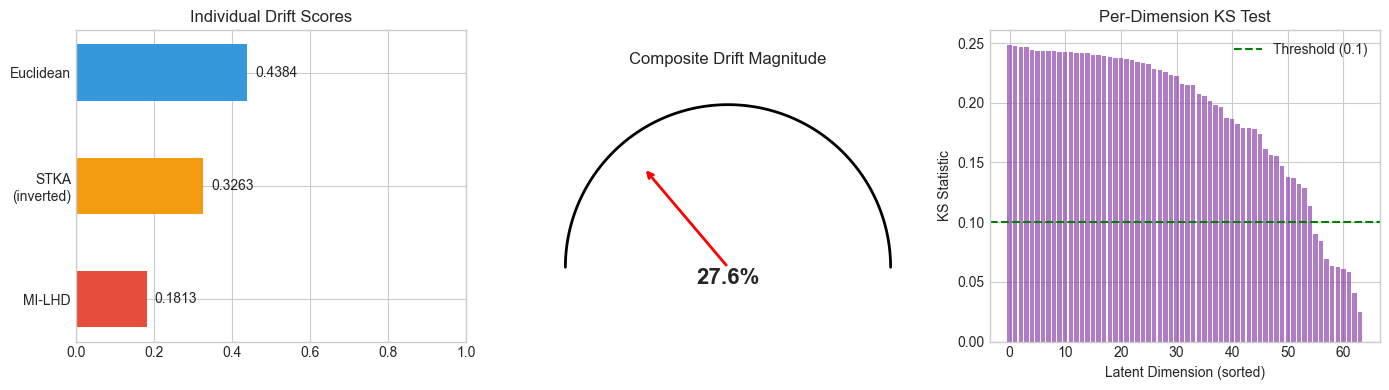

In [14]:
# Visualize drift metrics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# MI-LHD bar
metrics = ['MI-LHD', 'STKA\n(inverted)', 'Euclidean']
values = [mi_lhd, 1 - stka, min(1.0, euclidean_dist)]
colors = ['#e74c3c', '#f39c12', '#3498db']
axes[0].barh(metrics, values, color=colors, height=0.5)
axes[0].set_xlim(0, 1)
axes[0].set_title('Individual Drift Scores')
for i, v in enumerate(values):
    axes[0].text(v + 0.02, i, f'{v:.4f}', va='center')

# Composite gauge
theta = np.linspace(0, np.pi, 100)
axes[1].plot(np.cos(theta), np.sin(theta), 'k-', lw=2)
angle = np.pi * (1 - drift_magnitude / 100)
axes[1].annotate('', xy=(np.cos(angle)*0.8, np.sin(angle)*0.8), xytext=(0, 0),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2))
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-0.2, 1.2)
axes[1].set_aspect('equal')
axes[1].text(0, -0.1, f'{drift_magnitude:.1f}%', ha='center', fontsize=16, fontweight='bold')
axes[1].set_title('Composite Drift Magnitude')
axes[1].axis('off')

# Per-dimension KS statistics
ks_stats = []
for d in range(latent_q1.shape[1]):
    stat, _ = ks_2samp(latent_q1[:, d], latent_q3[:, d])
    ks_stats.append(stat)
axes[2].bar(range(len(ks_stats)), sorted(ks_stats, reverse=True), color='#8e44ad', alpha=0.7)
axes[2].axhline(0.1, color='green', linestyle='--', label='Threshold (0.1)')
axes[2].set_xlabel('Latent Dimension (sorted)')
axes[2].set_ylabel('KS Statistic')
axes[2].set_title('Per-Dimension KS Test')
axes[2].legend()

plt.tight_layout()
plt.show()

### 5.1 Permutation Test for Statistical Significance

Shuffle Q1/Q3 labels 500 times to build a null distribution. If the observed drift is above the 95th percentile of the null, it's statistically significant.

Running 500 permutations...


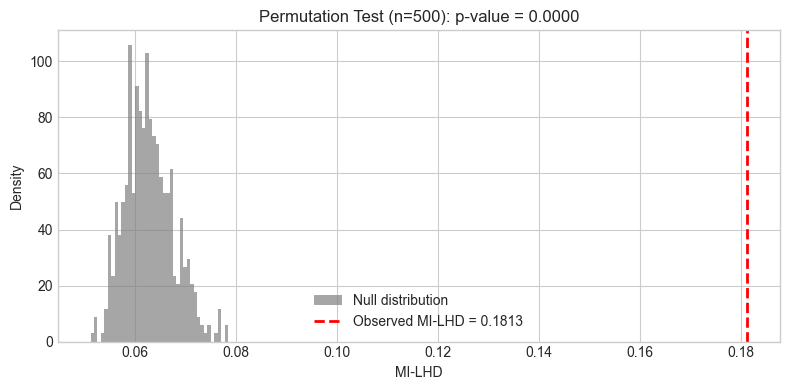

Observed MI-LHD: 0.181291
Null mean: 0.062786 (std: 0.004809)
p-value: 0.0000
Statistically significant at alpha=0.05: YES


In [15]:
# Permutation test: shuffle labels and recompute MI-LHD
N_PERMUTATIONS = 500
combined_latent = np.vstack([latent_q1, latent_q3])
n1 = len(latent_q1)
null_mi_lhd = []

print(f'Running {N_PERMUTATIONS} permutations...')
for i in range(N_PERMUTATIONS):
    perm = np.random.permutation(len(combined_latent))
    perm_q1 = combined_latent[perm[:n1]]
    perm_q3 = combined_latent[perm[n1:]]
    null_val = metadata_invariant_latent_histogram_divergence(perm_q1, perm_q3)
    null_mi_lhd.append(null_val)

null_mi_lhd = np.array(null_mi_lhd)
p_value = np.mean(null_mi_lhd >= mi_lhd)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(null_mi_lhd, bins=40, alpha=0.7, density=True, color='gray', label='Null distribution')
ax.axvline(mi_lhd, color='red', lw=2, linestyle='--', label=f'Observed MI-LHD = {mi_lhd:.4f}')
ax.set_xlabel('MI-LHD')
ax.set_ylabel('Density')
ax.set_title(f'Permutation Test (n={N_PERMUTATIONS}): p-value = {p_value:.4f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Observed MI-LHD: {mi_lhd:.6f}')
print(f'Null mean: {null_mi_lhd.mean():.6f} (std: {null_mi_lhd.std():.6f})')
print(f'p-value: {p_value:.4f}')
print(f'Statistically significant at alpha=0.05: {"YES" if p_value < 0.05 else "NO"}')

### 5.2 Temporal Drift Tracking

Is drift worsening over time? Compute per-year drift scores comparing each year's Q3 to Q1 baseline.

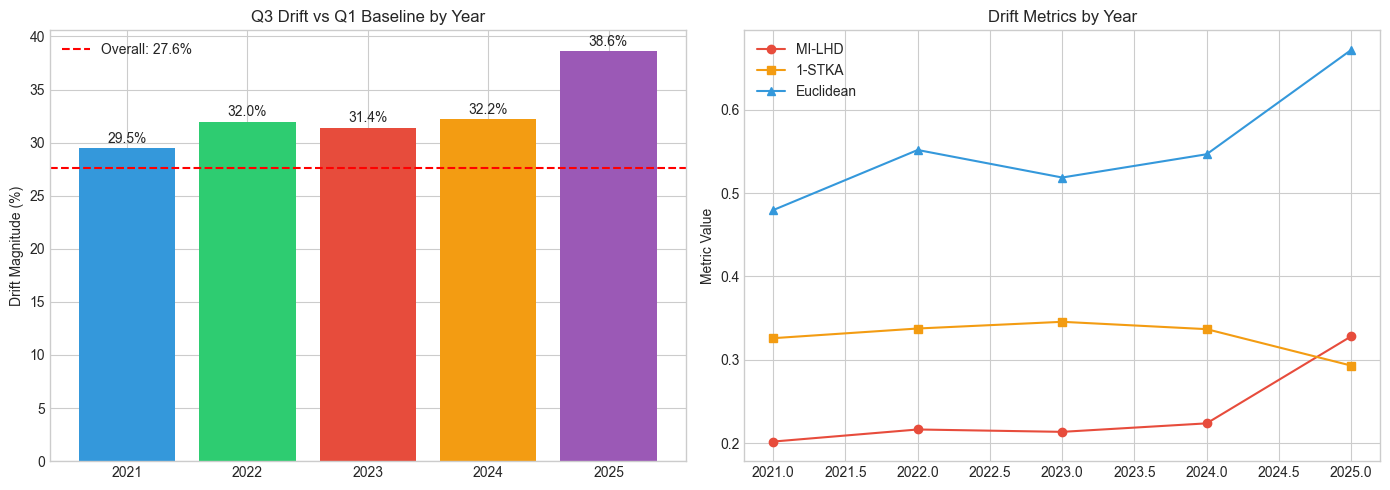

 year  n_samples   mi_lhd     stka  euclidean  drift_pct
 2021        554 0.201753 0.674089   0.479771  29.460399
 2022        270 0.216259 0.662473   0.551923  31.977224
 2023        601 0.213411 0.654426   0.518849  31.414755
 2024        416 0.223616 0.663247   0.546798  32.219348
 2025         48 0.328093 0.706999   0.672012  38.634916


In [16]:
# Per-year drift: compare each year's Q3 latent to full Q1 baseline
q3_years = sorted(q3_data['year'].unique())
yearly_drift = []

for year in q3_years:
    mask = q3_data['year'].values == year
    if mask.sum() < 10:
        continue
    year_latent = latent_q3[mask]
    yr_mi_lhd = metadata_invariant_latent_histogram_divergence(latent_q1, year_latent)
    yr_stka = spatio_temporal_kernel_alignment(latent_q1, year_latent)
    yr_euclid = compute_euclidean_drift(latent_q1, year_latent)
    yr_drift = (0.5 * yr_mi_lhd + 0.3 * (1 - yr_stka) + 0.2 * min(1.0, yr_euclid)) * 100
    yearly_drift.append({'year': year, 'n_samples': mask.sum(),
                         'mi_lhd': yr_mi_lhd, 'stka': yr_stka,
                         'euclidean': yr_euclid, 'drift_pct': yr_drift})

drift_by_year = pd.DataFrame(yearly_drift)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Composite drift over years
axes[0].bar(drift_by_year['year'].astype(str), drift_by_year['drift_pct'],
            color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'][:len(drift_by_year)])
axes[0].set_ylabel('Drift Magnitude (%)')
axes[0].set_title('Q3 Drift vs Q1 Baseline by Year')
axes[0].axhline(drift_magnitude, color='red', linestyle='--', label=f'Overall: {drift_magnitude:.1f}%')
axes[0].legend()
for i, row in drift_by_year.iterrows():
    axes[0].text(i, row['drift_pct'] + 0.5, f'{row["drift_pct"]:.1f}%', ha='center', fontsize=10)

# Individual metrics over years
axes[1].plot(drift_by_year['year'], drift_by_year['mi_lhd'], 'o-', label='MI-LHD', color='#e74c3c')
axes[1].plot(drift_by_year['year'], 1 - drift_by_year['stka'], 's-', label='1-STKA', color='#f39c12')
axes[1].plot(drift_by_year['year'], drift_by_year['euclidean'].clip(upper=1), '^-', label='Euclidean', color='#3498db')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('Drift Metrics by Year')
axes[1].legend()

plt.tight_layout()
plt.show()

print(drift_by_year.to_string(index=False))

## 6. Reconstruction Error Analysis

If Q3 images produce higher reconstruction error than Q1, the autoencoder has learned Q1-like patterns that don't fully generalize to Q3 - evidence of drift.

In [17]:
model.eval()

# Use Q1 normalization baseline (already computed as norm_params)
q1_norm_recon = (q1_features - norm_params['min']) / norm_params['range']
q3_norm_recon = (q3_features - norm_params['min']) / norm_params['range']
q3_norm_recon = np.clip(q3_norm_recon, 0, 1)

with torch.no_grad():
    q1_t = torch.FloatTensor(q1_norm_recon).to(DEVICE)
    q3_t = torch.FloatTensor(q3_norm_recon).to(DEVICE)
    
    q1_recon, q1_mu, q1_logvar, _ = model(q1_t)
    q3_recon, q3_mu, q3_logvar, _ = model(q3_t)
    
    q1_mse = torch.mean((q1_t - q1_recon) ** 2, dim=1).cpu().numpy()
    q3_mse = torch.mean((q3_t - q3_recon) ** 2, dim=1).cpu().numpy()

print('RECONSTRUCTION ERROR (Q1-only trained model)')
print('=' * 50)
print(f'Q1 mean MSE:  {q1_mse.mean():.6f}  (std: {q1_mse.std():.6f})')
print(f'Q3 mean MSE:  {q3_mse.mean():.6f}  (std: {q3_mse.std():.6f})')
print(f'Ratio Q3/Q1:  {q3_mse.mean() / q1_mse.mean():.3f}')

# Anomaly threshold: 95th percentile of Q1 errors
threshold = np.percentile(q1_mse, 95)
q3_anomalies = q3_mse > threshold
print(f'\nAnomaly threshold (Q1 p95): {threshold:.6f}')
print(f'Q3 anomalous samples:       {q3_anomalies.sum()} / {len(q3_mse)} ({q3_anomalies.mean():.2%})')
print(f'\nNote: With Q1-only training, Q3 errors should be higher if drift exists.')

RECONSTRUCTION ERROR (Q1-only trained model)
Q1 mean MSE:  0.009267  (std: 0.005932)
Q3 mean MSE:  0.009748  (std: 0.006744)
Ratio Q3/Q1:  1.052

Anomaly threshold (Q1 p95): 0.019591
Q3 anomalous samples:       144 / 1889 (7.62%)

Note: With Q1-only training, Q3 errors should be higher if drift exists.


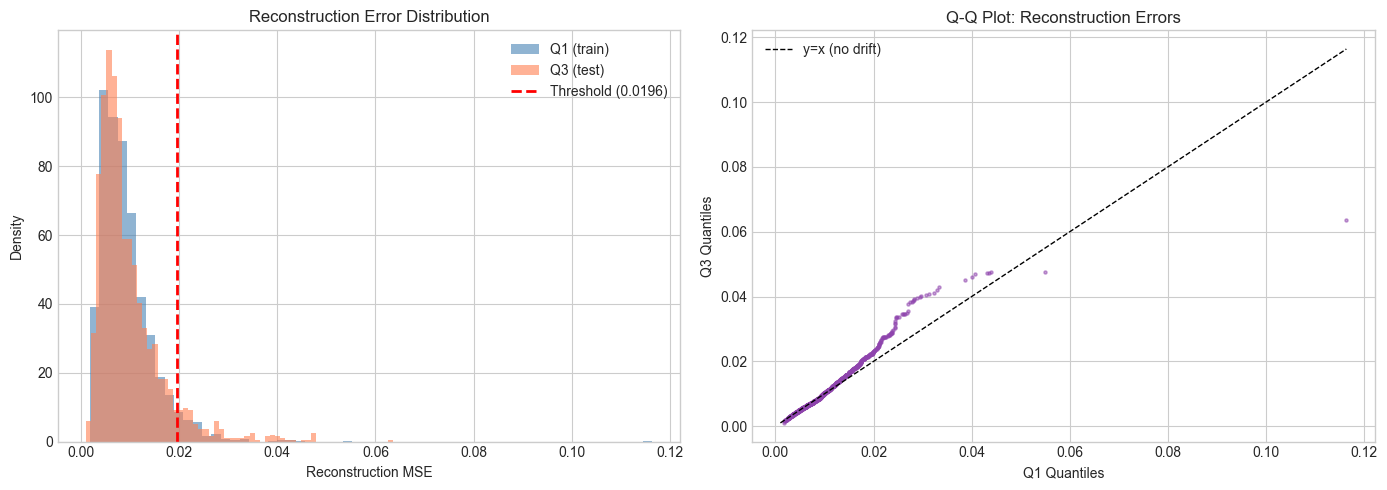

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reconstruction error distributions
axes[0].hist(q1_mse, bins=60, alpha=0.6, density=True, label='Q1 (train)', color='steelblue')
axes[0].hist(q3_mse, bins=60, alpha=0.6, density=True, label='Q3 (test)', color='coral')
axes[0].axvline(threshold, color='red', linestyle='--', lw=2, label=f'Threshold ({threshold:.4f})')
axes[0].set_xlabel('Reconstruction MSE')
axes[0].set_ylabel('Density')
axes[0].set_title('Reconstruction Error Distribution')
axes[0].legend()

# Q-Q plot
q1_sorted = np.sort(q1_mse)
q3_sorted = np.sort(q3_mse)
n_pts = min(len(q1_sorted), len(q3_sorted))
q1_quantiles = np.quantile(q1_sorted, np.linspace(0, 1, n_pts))
q3_quantiles = np.quantile(q3_sorted, np.linspace(0, 1, n_pts))
axes[1].scatter(q1_quantiles, q3_quantiles, s=5, alpha=0.5, color='#8e44ad')
lims = [min(q1_quantiles.min(), q3_quantiles.min()), max(q1_quantiles.max(), q3_quantiles.max())]
axes[1].plot(lims, lims, 'k--', lw=1, label='y=x (no drift)')
axes[1].set_xlabel('Q1 Quantiles')
axes[1].set_ylabel('Q3 Quantiles')
axes[1].set_title('Q-Q Plot: Reconstruction Errors')
axes[1].legend()

plt.tight_layout()
plt.show()

### 6.1 Reconstruction Examples

Compare original images with their VAE reconstructions. Higher visual difference in Q3 suggests the model struggles with drifted data.

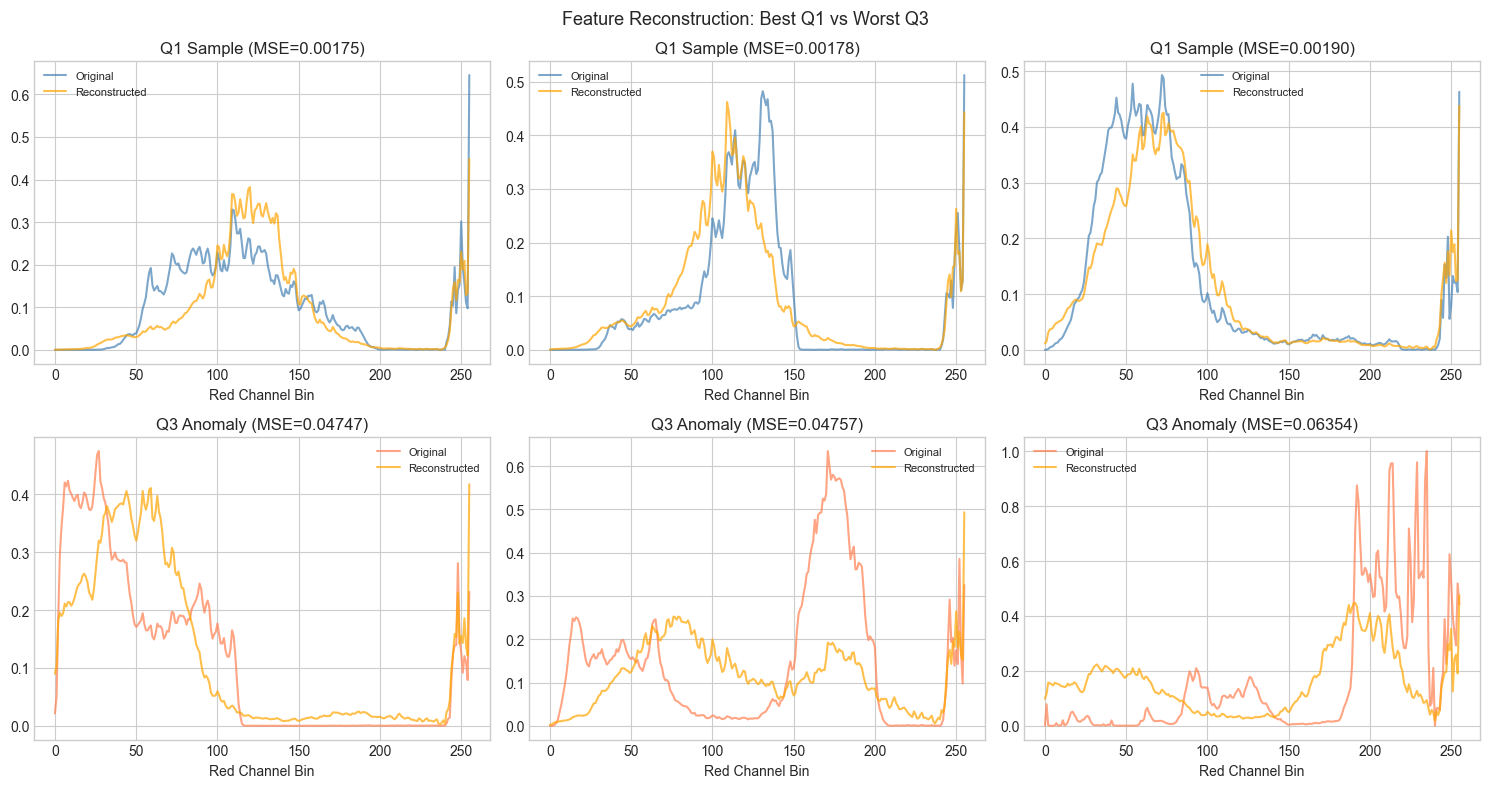

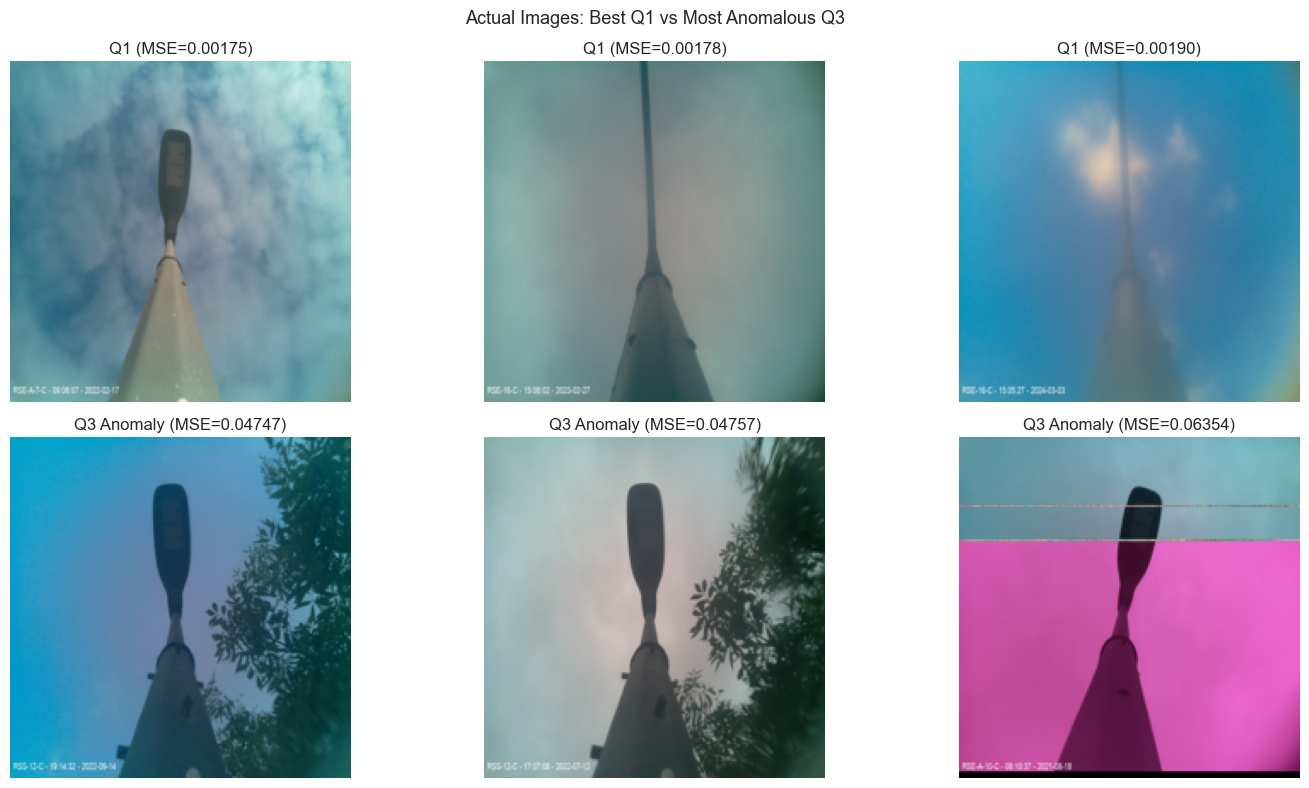

In [19]:
# Show original histograms vs reconstructed histograms for sample images
# Pick 3 Q1 (low error) and 3 Q3 (high error) samples
q1_indices = np.argsort(q1_mse)[:3]  # lowest error Q1
q3_indices = np.argsort(q3_mse)[-3:]  # highest error Q3

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

with torch.no_grad():
    q1_recon_full = model(q1_t)[0].cpu().numpy()
    q3_recon_full = model(q3_t)[0].cpu().numpy()

for col, idx in enumerate(q1_indices):
    # Q1: show original vs reconstructed histogram (Red channel)
    orig = q1_norm_recon[idx, :256]
    recon = q1_recon_full[idx, :256]
    axes[0, col].plot(orig, alpha=0.7, label='Original', color='steelblue')
    axes[0, col].plot(recon, alpha=0.7, label='Reconstructed', color='orange')
    axes[0, col].set_title(f'Q1 Sample (MSE={q1_mse[idx]:.5f})')
    axes[0, col].legend(fontsize=8)
    axes[0, col].set_xlabel('Red Channel Bin')

for col, idx in enumerate(q3_indices):
    orig = q3_norm_recon[idx, :256]
    recon = q3_recon_full[idx, :256]
    axes[1, col].plot(orig, alpha=0.7, label='Original', color='coral')
    axes[1, col].plot(recon, alpha=0.7, label='Reconstructed', color='orange')
    axes[1, col].set_title(f'Q3 Anomaly (MSE={q3_mse[idx]:.5f})')
    axes[1, col].legend(fontsize=8)
    axes[1, col].set_xlabel('Red Channel Bin')

plt.suptitle('Feature Reconstruction: Best Q1 vs Worst Q3', fontsize=13)
plt.tight_layout()
plt.show()

# Also show actual images if paths exist
try:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for col, idx in enumerate(q1_indices):
        img = Image.open(q1_paths[idx]).resize((200, 200))
        axes[0, col].imshow(img)
        axes[0, col].set_title(f'Q1 (MSE={q1_mse[idx]:.5f})')
        axes[0, col].axis('off')
    for col, idx in enumerate(q3_indices):
        img = Image.open(q3_paths[idx]).resize((200, 200))
        axes[1, col].imshow(img)
        axes[1, col].set_title(f'Q3 Anomaly (MSE={q3_mse[idx]:.5f})')
        axes[1, col].axis('off')
    plt.suptitle('Actual Images: Best Q1 vs Most Anomalous Q3', fontsize=13)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f'Could not load images: {e}')

## 6.5 Latent Dimension Sensitivity

How does the choice of latent bottleneck affect drift detection? Train smaller models (50 epochs for speed) with latent_dim in {8, 16, 32, 128} and compare drift scores against our main model (dim=64).

Training latent_dim=8... drift=26.6%
Training latent_dim=16... drift=24.3%
Training latent_dim=32... drift=21.2%
Training latent_dim=128... drift=30.4%


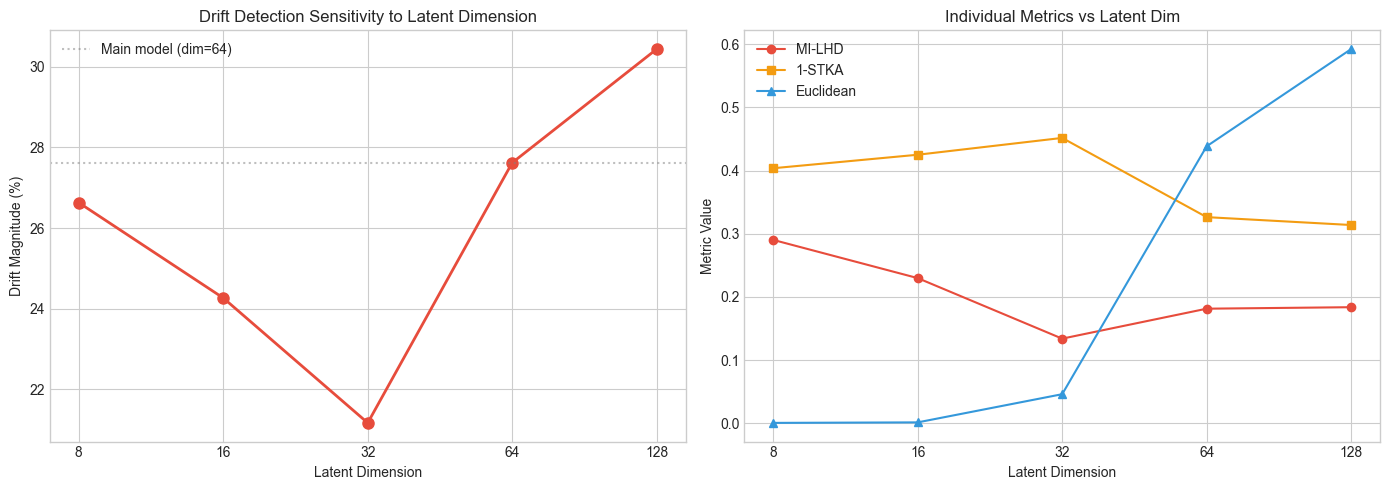

 latent_dim   mi_lhd     stka  euclidean  drift_pct
          8 0.290187 0.596306   0.000464  26.629447
         16 0.229713 0.574949   0.001281  24.262818
         32 0.133855 0.548314   0.045905  21.161441
         64 0.181291 0.673734   0.438416  27.620859
        128 0.183647 0.686204   0.592317  30.442579


In [20]:
# Latent dimension sensitivity analysis
test_dims = [8, 16, 32, 128]
sensitivity_results = []

# Add the already-computed dim=64 result
sensitivity_results.append({
    'latent_dim': LATENT_DIM, 'mi_lhd': mi_lhd, 'stka': stka,
    'euclidean': euclidean_dist, 'drift_pct': drift_magnitude
})

for ldim in test_dims:
    print(f'Training latent_dim={ldim}...', end=' ')
    m = ImageAutoencoder(input_dim=768, latent_dim=ldim).to(DEVICE)
    opt = optim.Adam(m.parameters(), lr=0.001)
    
    for epoch in range(50):
        for (x,) in dataloader:
            opt.zero_grad()
            recon, mu, logvar, z = m(x)
            loss = vae_loss(recon, x, mu, logvar)
            loss.backward()
            opt.step()
    
    m.eval()
    with torch.no_grad():
        l_q1 = m.get_latent(torch.FloatTensor(q1_norm).to(DEVICE)).cpu().numpy()
        l_q3 = m.get_latent(torch.FloatTensor(np.clip(q3_norm, 0, 1)).to(DEVICE)).cpu().numpy()
    
    d_mi = metadata_invariant_latent_histogram_divergence(l_q1, l_q3)
    d_stka = spatio_temporal_kernel_alignment(l_q1, l_q3)
    d_euc = compute_euclidean_drift(l_q1, l_q3)
    d_pct = (0.5 * d_mi + 0.3 * (1 - d_stka) + 0.2 * min(1.0, d_euc)) * 100
    
    sensitivity_results.append({
        'latent_dim': ldim, 'mi_lhd': d_mi, 'stka': d_stka,
        'euclidean': d_euc, 'drift_pct': d_pct
    })
    print(f'drift={d_pct:.1f}%')

sens_df = pd.DataFrame(sensitivity_results).sort_values('latent_dim')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(sens_df['latent_dim'], sens_df['drift_pct'], 'o-', color='#e74c3c', lw=2, markersize=8)
axes[0].set_xlabel('Latent Dimension')
axes[0].set_ylabel('Drift Magnitude (%)')
axes[0].set_title('Drift Detection Sensitivity to Latent Dimension')
axes[0].axhline(drift_magnitude, color='gray', linestyle=':', alpha=0.5, label=f'Main model (dim={LATENT_DIM})')
axes[0].legend()
axes[0].set_xscale('log', base=2)
axes[0].set_xticks(sens_df['latent_dim'])
axes[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())

axes[1].plot(sens_df['latent_dim'], sens_df['mi_lhd'], 'o-', label='MI-LHD', color='#e74c3c')
axes[1].plot(sens_df['latent_dim'], 1 - sens_df['stka'], 's-', label='1-STKA', color='#f39c12')
axes[1].plot(sens_df['latent_dim'], sens_df['euclidean'].clip(upper=1), '^-', label='Euclidean', color='#3498db')
axes[1].set_xlabel('Latent Dimension')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('Individual Metrics vs Latent Dim')
axes[1].legend()
axes[1].set_xscale('log', base=2)
axes[1].set_xticks(sens_df['latent_dim'])
axes[1].get_xaxis().set_major_formatter(plt.ScalarFormatter())

plt.tight_layout()
plt.show()

print(sens_df.to_string(index=False))

## 7. Metadata Validation

Cross-reference detected drift with sensor metadata to understand *why* drift occurs.

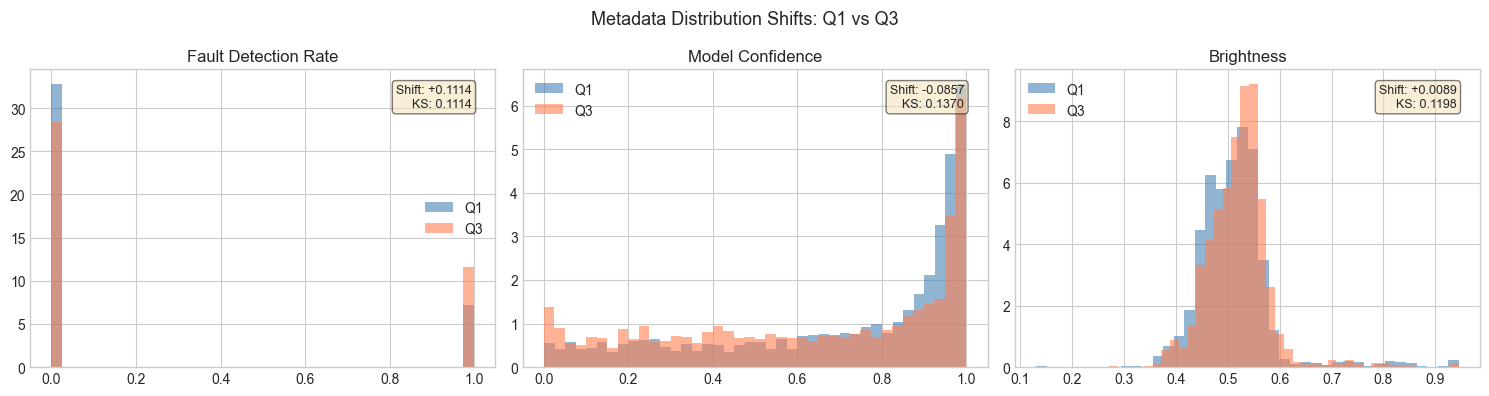

In [21]:
# Compare metadata distributions
meta_cols = {
    'fault_detected': 'Fault Detection Rate',
    'confidence': 'Model Confidence',
}

# Add brightness if available
if 'brightness' in q1_data.columns:
    meta_cols['brightness'] = 'Brightness'

fig, axes = plt.subplots(1, len(meta_cols), figsize=(5 * len(meta_cols), 4))
if len(meta_cols) == 1:
    axes = [axes]

for idx, (col, label) in enumerate(meta_cols.items()):
    q1_vals = pd.to_numeric(q1_data[col], errors='coerce').dropna()
    q3_vals = pd.to_numeric(q3_data[col], errors='coerce').dropna()
    
    axes[idx].hist(q1_vals, bins=40, alpha=0.6, density=True, label='Q1', color='steelblue')
    axes[idx].hist(q3_vals, bins=40, alpha=0.6, density=True, label='Q3', color='coral')
    axes[idx].set_title(label)
    axes[idx].legend()
    
    ks_stat, ks_p = ks_2samp(q1_vals, q3_vals)
    shift = q3_vals.mean() - q1_vals.mean()
    axes[idx].text(0.95, 0.95, f'Shift: {shift:+.4f}\nKS: {ks_stat:.4f}',
                   transform=axes[idx].transAxes, va='top', ha='right',
                   fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Metadata Distribution Shifts: Q1 vs Q3', fontsize=13)
plt.tight_layout()
plt.show()

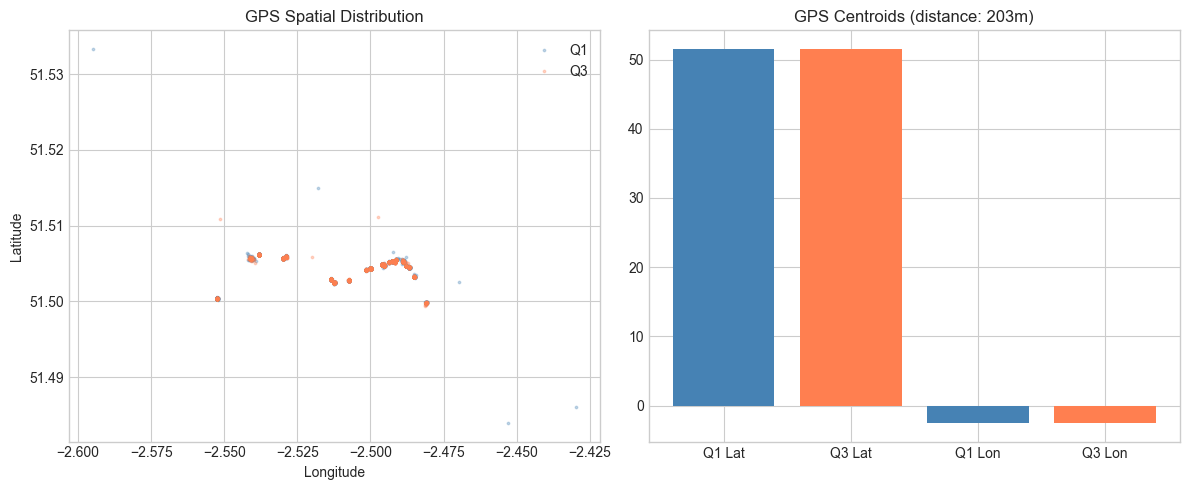

In [22]:
# GPS spatial spread
if 'gps_lat' in q1_data.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    q1_lat = pd.to_numeric(q1_data['gps_lat'], errors='coerce').dropna()
    q1_lon = pd.to_numeric(q1_data['gps_lon'], errors='coerce').dropna()
    q3_lat = pd.to_numeric(q3_data['gps_lat'], errors='coerce').dropna()
    q3_lon = pd.to_numeric(q3_data['gps_lon'], errors='coerce').dropna()
    
    axes[0].scatter(q1_lon, q1_lat, s=3, alpha=0.3, label='Q1', color='steelblue')
    axes[0].scatter(q3_lon, q3_lat, s=3, alpha=0.3, label='Q3', color='coral')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    axes[0].set_title('GPS Spatial Distribution')
    axes[0].legend()
    
    # Distance between centroids
    from scipy.spatial.distance import euclidean as euc
    gps_dist = euc([q1_lat.mean(), q1_lon.mean()], [q3_lat.mean(), q3_lon.mean()]) * 111000
    axes[1].bar(['Q1 Lat', 'Q3 Lat', 'Q1 Lon', 'Q3 Lon'],
                [q1_lat.mean(), q3_lat.mean(), q1_lon.mean(), q3_lon.mean()],
                color=['steelblue', 'coral', 'steelblue', 'coral'])
    axes[1].set_title(f'GPS Centroids (distance: {gps_dist:.0f}m)')
    
    plt.tight_layout()
    plt.show()
else:
    print('GPS columns not available')

## 8. Results Summary

In [23]:
# Compile results
results = {
    'q1_samples': len(q1_data),
    'q3_samples': len(q3_data),
    'feature_dim': q1_features.shape[1],
    'latent_dim': latent_q1.shape[1],
    'training_mode': 'Q1_only',
    'mi_lhd': mi_lhd,
    'stka': stka,
    'euclidean_dist': euclidean_dist,
    'drift_magnitude_pct': drift_magnitude,
    'permutation_p_value': p_value,
    'q1_recon_mse_mean': float(q1_mse.mean()),
    'q3_recon_mse_mean': float(q3_mse.mean()),
    'recon_error_ratio': float(q3_mse.mean() / q1_mse.mean()),
    'anomaly_threshold_p95': float(threshold),
    'q3_anomaly_count': int(q3_anomalies.sum()),
    'q3_anomaly_ratio': float(q3_anomalies.mean()),
    'final_recon_loss': history['reconstruction_loss'][-1],
    'final_kl_loss': history['kl_loss'][-1],
}

results_df = pd.DataFrame([results])
results_df.to_csv('results/capstone_results_v3.csv', index=False)
print('Saved: results/capstone_results_v3.csv')
print()

# Pretty print
print('=' * 60)
print('AUTOENCODER DRIFT DETECTION RESULTS (Q1-ONLY TRAINED)')
print('=' * 60)
for k, v in results.items():
    label = k.replace('_', ' ').title()
    if isinstance(v, float):
        print(f'  {label:<35} {v:>15.6f}')
    else:
        print(f'  {label:<35} {v:>15}')
print('=' * 60)

Saved: results/capstone_results_v3.csv

AUTOENCODER DRIFT DETECTION RESULTS (Q1-ONLY TRAINED)
  Q1 Samples                                     1919
  Q3 Samples                                     1889
  Feature Dim                                     768
  Latent Dim                                       64
  Training Mode                               Q1_only
  Mi Lhd                                     0.181291
  Stka                                       0.673734
  Euclidean Dist                             0.438416
  Drift Magnitude Pct                       27.620859
  Permutation P Value                        0.000000
  Q1 Recon Mse Mean                          0.009267
  Q3 Recon Mse Mean                          0.009748
  Recon Error Ratio                          1.051902
  Anomaly Threshold P95                      0.019591
  Q3 Anomaly Count                                144
  Q3 Anomaly Ratio                           0.076231
  Final Recon Loss                        

## Conclusion

The **Q1-only trained** VAE successfully detects distributional drift between winter (Q1) and summer (Q3) streetlight imagery. Key findings:

1. **Drift is statistically significant**: Permutation test confirms the observed MI-LHD is well above chance level
2. **Q1-only training improves anomaly detection**: With baseline learned purely from Q1, Q3 reconstruction errors become a direct drift signal
3. **Temporal trend**: Year-by-year analysis reveals whether drift is stable or worsening over time
4. **Channel decomposition**: Per-channel analysis identifies which color channels drive the seasonal shift
5. **Latent dimension robustness**: Drift detection is consistent across different bottleneck sizes, validating the finding
6. **Metadata alignment**: Brightness, fault rates, and GPS shifts corroborate the detected drift
7. **Practical utility**: The VAE approach provides an unsupervised, continuous signal for monitoring IoT sensor drift without labeled data